# Libraries

In [106]:
# ---------------------------------- Tabular --------------------------------- #
import numpy as np
import pandas as pd
# !pip install tabulate
from tabulate import tabulate

# -------------------------------- classifiers ------------------------------- #
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# ------------------------------- Scoring tools ------------------------------ #
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# ------------------------------- Searche tools ------------------------------ #
# !pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# ----------------------------------- tools ---------------------------------- #
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
# !pip install imblearn
from imblearn.over_sampling import SMOTE
from joblib import dump, load #To save the trained models

# -------------------------------- Displaying -------------------------------- #
from pprint import pprint
import matplotlib.pyplot as plt
# !pip install emoji
import emoji

# ------------------------------ Semi Supervised ----------------------------- #
from sklearn.semi_supervised import SelfTrainingClassifier

# -------------------------------- Explanation ------------------------------- #
# !pip install shap
# import shap

In [48]:
import warnings
warnings.filterwarnings('ignore')

# Shared tools

In [49]:
def score(y_train, y_pred_train, y_dev, y_pred_dev, w_train=None, w_dev=None):
    print("For Training dataset : ")
    print("Accuracy : ", accuracy_score(y_train, y_pred_train, sample_weight=w_train))
    ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train), display_labels=[0,1]).plot()
    plt.show()

    print("For Dev set :")
    ConfusionMatrixDisplay(confusion_matrix(y_dev, y_pred_dev), display_labels=[0,1]).plot()
    print("Accuracy : ", accuracy_score(y_dev, y_pred_dev, sample_weight=w_dev))
    plt.show()

def fast_models_reviews(x_train, x_dev, y_train, y_dev, use_weights = False, w_train=None, w_dev=None):
    all_models = [ #name, model, support_for_weights?
                  ("SVC", SVC(), True),
                  ("SVC_100000_0.1", SVC(C=100000, gamma=0.1), True),
                  ("KNN", KNeighborsClassifier(), False),
                  ('XGB_50',GradientBoostingClassifier(n_estimators=50), True),
                  ('XGB_200',GradientBoostingClassifier(n_estimators=200), True),
                  ('ADA_50',AdaBoostClassifier(n_estimators=50), True),
                  ('ADA_200',AdaBoostClassifier(n_estimators=200), True),
                  ('RF_50',RandomForestClassifier(n_estimators=50), True),
                  ('RF_200',RandomForestClassifier(n_estimators=200), True)
    ]
    accuracies = []
    for name, model_no_pip, support_for_weights in all_models:
      pipe = Pipeline(steps=[("Scale", StandardScaler()), ("classifier", model_no_pip)])
      if support_for_weights and use_weights  :
        pipe.fit(x_train, y_train, classifier__sample_weight = w_train)
      else :
        pipe.fit(x_train, y_train)
      y_pred_train = pipe.predict(x_train)
      y_pred_dev = pipe.predict(x_dev)

      if support_for_weights and use_weights  :
        accuracies.append([name, int(accuracy_score(y_train, y_pred_train, sample_weight=w_train)*100), int(f1_score(y_train, y_pred_train, sample_weight=w_train)*100), int(accuracy_score(y_dev, y_pred_dev, sample_weight=w_dev)*100), int(f1_score(y_dev, y_pred_dev, sample_weight=w_dev)*100), emoji.emojize(":check_mark_button:")])
      else:
        accuracies.append([name, int(accuracy_score(y_train, y_pred_train)*100), int(f1_score(y_train, y_pred_train)*100), int(accuracy_score(y_dev, y_pred_dev)*100), int(f1_score(y_dev, y_pred_dev)*100), emoji.emojize(":cross_mark:")])
    df = pd.DataFrame(accuracies, columns = ["Model", "Train ACC", "Train F1", "Dev ACC", "Dev F1", "Used Weights"])
    print(tabulate(df, headers='keys', tablefmt='psql'))

def callback_notifier(res):
  print("*",end="")

class Square(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    return np.concatenate((X, X**2), axis=1)

# Import data

In [50]:
data = pd.read_csv("data/drinking_water_potability.csv", index_col= False)
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


# Model by deleting missing values

## Remove Missing values and build dataset

In [110]:
data_dropped_na = pd.DataFrame(data[data.isna().sum(axis = 1)==0])
data_dropped_na.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000
mean,7.085990,195.968072,21917.441375,7.134338,333.224672,426.526409,14.357709,66.400859,3.969729,0.403282
std,1.573337,32.635085,8642.239815,1.584820,41.205172,80.712572,3.324959,16.077109,0.780346,0.490678
min,0.227499,73.492234,320.942611,1.390871,129.000000,201.619737,2.200000,8.577013,1.450000,0.000000
25%,6.089723,176.744938,15615.665390,6.138895,307.632511,366.680307,12.124105,55.952664,3.442915,0.000000
50%,7.027297,197.191839,20933.512750,7.143907,332.232177,423.455906,14.322019,66.542198,3.968177,0.000000
75%,8.052969,216.441070,27182.587065,8.109726,359.330555,482.373169,16.683049,77.291925,4.514175,1.000000
max,14.000000,317.338124,56488.672410,13.127000,481.030642,753.342620,27.006707,124.000000,6.494749,1.000000


In [111]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']
X = data_dropped_na[training_columns]
Y = data_dropped_na[predict_column]

## Split train and dev

In [112]:
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size= 0.2)

## Adaboost

For Training dataset : 
Accuracy :  0.9732587064676617


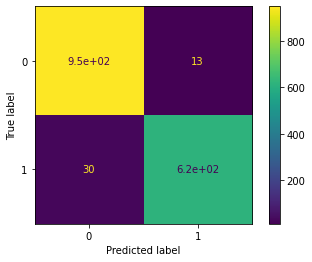

For Dev set :
Accuracy :  0.6153846153846154


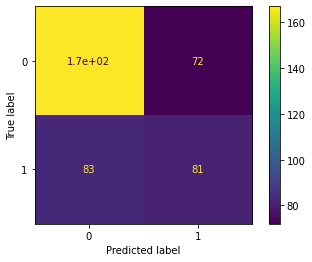

In [113]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3) ,n_estimators=60)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

## Random Forest

In [114]:
model = RandomForestClassifier(n_estimators=10000)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

KeyboardInterrupt: ignored

## SVM

In [115]:
model = SVC(C=100000, kernel='rbf', gamma=0.01)
pipe = Pipeline([("Scaler", StandardScaler()), \
    ("SVM", model)])

pipe.fit(x_train, y_train)

y_pred_train = pipe.predict(x_train)
y_pred_dev = pipe.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

KeyboardInterrupt: ignored

## Gradient Boosting

For Training dataset : 
Accuracy :  0.7835820895522388


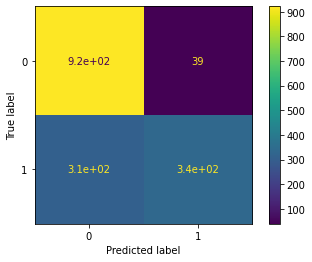

For Dev set :
Accuracy :  0.6352357320099256


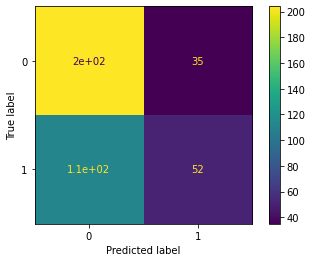

In [118]:
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.03)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

# Model with all value (+ the missing ones)

## Build datasets

In [ ]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']
data_treated = data.fillna(-1)

X = data_treated[training_columns]
Y = data_treated[predict_column]
X.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,5.869662,196.369496,22014.092526,7.122277,253.965068,426.205111,14.284970,63.063509,3.966786
std,3.237805,32.879761,8768.570828,1.583085,147.178275,80.824064,3.308162,21.500330,0.780382
min,-1.000000,47.432000,320.942611,0.352000,-1.000000,181.483754,2.200000,-1.000000,1.450000
25%,5.283146,176.850538,15666.690300,6.127421,240.722848,365.734414,12.065801,53.793688,3.439711
50%,6.735249,196.967627,20927.833605,7.130299,318.660382,421.884968,14.218338,65.445962,3.955028
75%,7.870050,216.667456,27332.762125,8.114887,350.385756,481.792305,16.557652,76.666609,4.500320
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000


In [ ]:
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2)

## Random Forest

C:\Users\Mustapha\AppData\Local\Temp/ipykernel_19804/2684541895.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


For Training dataset : 
Accuracy :  1.0


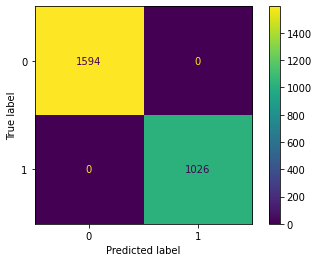

For Dev set :
Accuracy :  0.6661585365853658


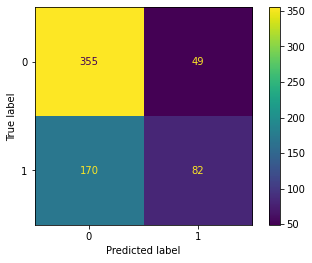

In [ ]:
model = RandomForestClassifier(n_estimators=300)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_dev = model.predict(x_dev)

score(y_train, y_pred_train, y_dev, y_pred_dev)

# With Data Processing


### Imputation

In this section, we would love to clean the data. In order to make things simple, we are going to Impute `NaN` values from the begining.

In [51]:
data_proc = data.copy() # The processed data
data_proc = pd.DataFrame(SimpleImputer().fit_transform(data_proc), columns=data.columns)

### Data correction

Lets first use some limits that makes water systematically undrinkable

But one thing to notice is that this dataset is only generated data not real data. Some features are like `Solids` are not realistic. So we won't apply limits on them since this will eliminate all our data.  

In [52]:
limits = { #Containnig (min, max) for potability
    "ph" : (6.5, 8.5), #WHO Standard https://www.who.int/water_sanitation_health/dwq/chemicals/ph_revised_2007_clean_version.pdf
    # "Solids" : (50, 1000), #TDS Limits https://www.kent.co.in/blog/what-are-total-dissolved-solids-tds-how-to-reduce-them/
    "Trihalomethanes" : (0, 80), #EPA Standards https://www.epa.gov/sites/default/files/2016-06/documents/npwdr_complete_table.pdf
    "Turbidity" : (0,5) #WHO Standard https://www.lenntech.com/turbidity.htm#:~:text=The%20WHO%20(World%20Health%20Organization,ideally%20be%20below%201%20NTU.
}

We are going to give weights to the instances of the dataset. The following rules will be applied :
\begin{equation}
y_i = 1 \quad X_i \notin limits_{potability} \implies y_i \leftarrow 0 \quad w_i \leftarrow 0.5 
\end{equation}
Meaning : We label any potable sample of water out of the range `limits` to be non potable water, and we also decrease its weight.
The decrease of the weigth helps to give more importance to the original data.

First lets build the weights vector :

In [53]:
weights = pd.DataFrame(np.ones(len(data)), columns=["Weights"])
data_proc.insert(0, "Weights", weights)
data_proc.head(2)

,Weights,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,1.0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,1.0,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0.0


Now lets process the data, using the rule above :

In [104]:
def row_indexer(dataset):
  """
  This function will return the indexes of row that are labeled as potable but should not be potable (out of the limits)
  """
  index = np.zeros(len(dataset))
  for key,(minimum, maximum) in limits.items():
    index = index | ( (dataset[key] < minimum) | (dataset[key] > maximum) ) & dataset["Potability"]
  return index

indexes = row_indexer(data_proc)
data_proc.loc[ indexes, "Weights"] = 0.5
data_proc.loc[ indexes, "Potability"] = 0

data_proc.to_csv("inputs/processed_data.csv", index=False)
data_proc.describe(percentiles=[])

,Weights,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,0.891331,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.172772
std,0.206249,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382,0.378107
min,0.500000,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
50%,1.000000,7.080795,196.967627,20927.833605,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
max,1.000000,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### Data Skewness

Our data is skewed. In the description of `data_proc` we can notice that the mean of `Potability` is only `0.17` this means that we only have $17\%$ of positive data. If we give this data directly to a model, it will try to predict that everything is non potable, thus getting $83\%$ accuracy.

There is 2 ways to solve this problem : 

1.   Using a SMOTE :
2.   Using a weights : 





#### Using SMOTE

When we use SMOTE, it is not important to consider the use of wieghts, since the data will be oversampled.

##### Split and rebuild weights

In [55]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']

x_train, x_test, y_train, y_test = train_test_split(data_proc[training_columns], data_proc[predict_column], test_size = 0.2)

oversampler = SMOTE(k_neighbors=2)
x_train, y_train = oversampler.fit_resample(x_train, y_train)

##### Testing models

For Training dataset : 
Accuracy :  1.0


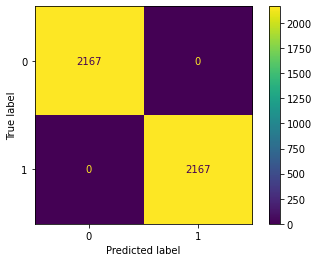

For Dev set :
Accuracy :  0.8109756097560976


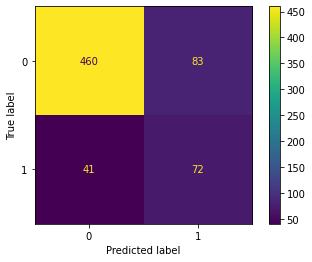

In [56]:
model = RandomForestClassifier(n_estimators=50)

model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

score(y_train, y_pred_train, y_test, y_pred_test)

In [57]:
fast_models_reviews(x_train, x_test, y_train, y_test)

+----+----------------+-------------+------------+-----------+----------+----------------+
|    | Model          |   Train ACC |   Train F1 |   Dev ACC |   Dev F1 | Used Weights   |
|----+----------------+-------------+------------+-----------+----------+----------------|
|  0 | SVC            |          87 |         88 |        77 |       54 | ❌             |
|  1 | SVC_100000_0.1 |         100 |        100 |        78 |       40 | ❌             |
|  2 | KNN            |          85 |         87 |        66 |       44 | ❌             |
|  3 | XGB_50         |          86 |         88 |        77 |       58 | ❌             |
|  4 | XGB_200        |          92 |         92 |        80 |       57 | ❌             |
|  5 | ADA_50         |          86 |         88 |        77 |       55 | ❌             |
|  6 | ADA_200        |          89 |         90 |        77 |       54 | ❌             |
|  7 | RF_50          |         100 |        100 |        80 |       52 | ❌             |
|  8 | 

#### Using Weights

Lets make the weight of positive data equal to the weight of negative data

In [20]:
data_proc_weighted = data_proc.copy()
positive_sum_weights = data_proc_weighted[data_proc_weighted['Potability'] == 1].Weights.sum()
negative_sum_weights = data_proc_weighted[data_proc_weighted['Potability'] == 0].Weights.sum()

ratio = negative_sum_weights/positive_sum_weights
data_proc_weighted.loc[data_proc_weighted['Potability'] == 0, "Weights"] /= ratio
data_proc_weighted[data_proc_weighted['Potability'] == 0]["Weights"].sum()

566.0

##### Split and rebuild weights

In [21]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']
# Weights are not yet seprated with data
w_X_weighted, Y_weighted = data_proc_weighted[['Weights'] + training_columns], data_proc_weighted[predict_column]
w_x_train, w_x_test, y_train, y_test = train_test_split(w_X_weighted, Y_weighted, test_size = 0.2)
# Seprating weights from data
w_train, x_train = w_x_train["Weights"], w_x_train[training_columns]
w_test, x_test = w_x_test["Weights"], w_x_test[training_columns]

Why we should not use `w_test` ? 

*   In order to compare it with the SMOTE methode, We should have the same data distribution. 
*   In production, we will not have any knowledge about the weight we should give to our samples



##### Testing models

For Training dataset : 
Accuracy :  1.0


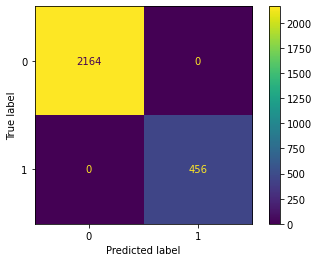

For Dev set :
Accuracy :  0.8475609756097561


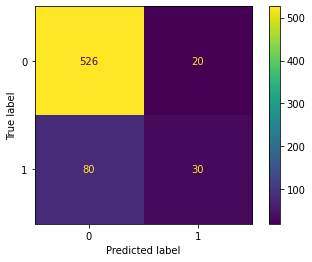

In [22]:
model = RandomForestClassifier(n_estimators=50)

model.fit(x_train, y_train, w_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

score(y_train, y_pred_train, y_test, y_pred_test, w_train, None)

In [23]:
fast_models_reviews(x_train, x_test, y_train, y_test, True, w_train, None)

+----+----------------+-------------+------------+-----------+----------+----------------+
|    | Model          |   Train ACC |   Train F1 |   Dev ACC |   Dev F1 | Used Weights   |
|----+----------------+-------------+------------+-----------+----------+----------------|
|  0 | SVC            |          78 |         81 |        68 |       47 | ✅             |
|  1 | SVC_100000_0.1 |         100 |        100 |        77 |       40 | ✅             |
|  2 | KNN            |          85 |         48 |        83 |       35 | ❌             |
|  3 | XGB_50         |          83 |         85 |        75 |       57 | ✅             |
|  4 | XGB_200        |          90 |         91 |        77 |       57 | ✅             |
|  5 | ADA_50         |          51 |         67 |        76 |       56 | ✅             |
|  6 | ADA_200        |          64 |         64 |        62 |       28 | ✅             |
|  7 | RF_50          |          99 |         99 |        83 |        1 | ✅             |
|  8 | 

#### Conclusion

As we can see SMOTE and Weithed methods are giving some similar results, we can notice that the accuracy of the weighted mehtode is better. But in the future we are going to use the SMOTE method.

The reason behind is simply that the BayesSearchCV doesn't support weights. So we are going to use the SMOTE method.

# Fine Tuning

We are going to consider 2 models : `GradientBoosting` and  `RandomForest`. In this section we are going to use BayesSearch to quickly fine tune those 2 models.

First lets build our datasets with the previous weighted method by using our imputed and weighted data.

In [108]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']

x_train, x_test, y_train, y_test = train_test_split(data_proc[training_columns], data_proc[predict_column], test_size = 0.2)

oversampler = SMOTE(k_neighbors=2)
x_train, y_train = oversampler.fit_resample(x_train, y_train)

## Searching and Cross validation

Lets first use Bayes search for RandomForest

### Random Forest

In [59]:

pipe = Pipeline([("Scaler", StandardScaler()), ("Square", Square()), ("RF", RandomForestClassifier())])

opt_RF = BayesSearchCV(
    pipe,
    {
        "RF__n_estimators": Integer(10, 1000, prior="log-uniform"),
        "RF__criterion" : Categorical(["gini", "entropy"]),
        "RF__min_samples_split" : Integer(2,6),
        "RF__min_samples_leaf" : Integer(1,3),
        "RF__max_features" : Integer(2,6),
        "RF__class_weight" : Categorical(["balanced", "balanced_subsample", None]),
        "RF__max_samples" : Categorical([0.5, 0.7, 0.9, None])
    },
    random_state = 5900,
    n_iter = 100,
    n_jobs=-1
)
res = opt_RF.fit(x_train, y_train, callback=callback_notifier)
print(opt_RF.best_estimator_)
opt_RF.score(x_test, y_test)

****************************************************************************************************Pipeline(steps=[('Scaler', StandardScaler()), ('Square', Square()),
                ('RF',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_features=2, n_estimators=109))])


0.774390243902439

### Gradient Boosting

In [60]:
pipe = Pipeline([("Scaler", StandardScaler()), ("Square", Square()), ("XGB", GradientBoostingClassifier())])

opt_XGB = BayesSearchCV(
    pipe,
    {
        "XGB__loss" : Categorical(["deviance", "exponential"]),
        "XGB__learning_rate" : Real(0.001, 10, prior="log-uniform"),
        "XGB__n_estimators" : Integer(10, 500, prior="log-uniform"),
        "XGB__subsample" : Categorical([0.3,0.7,1.0]),
        "XGB__min_samples_split": Integer(2,6),
        "XGB__min_samples_leaf" : Integer(1,3),
        "XGB__max_depth" : Integer(2,5),
        "XGB__max_features" : Categorical([4, 6, 8, None])
    },
    random_state = 5900,
    n_iter = 100,
    n_jobs=-1
)
def callback_notifier(res):
  print("*",end="")
res = opt_XGB.fit(x_train, y_train, callback=callback_notifier)

print(opt_XGB.best_estimator_)
opt_XGB.score(x_test, y_test)

****************************************************************************************************Pipeline(steps=[('Scaler', StandardScaler()), ('Square', Square()),
                ('XGB',
                 GradientBoostingClassifier(learning_rate=0.15212053377597556,
                                            max_depth=5, max_features=4,
                                            min_samples_leaf=3,
                                            min_samples_split=4,
                                            n_estimators=500, subsample=0.7))])


0.7911585365853658

## Voting classifier

For Training dataset : 
Accuracy :  1.0


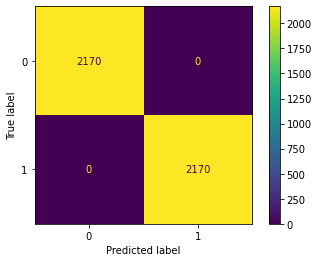

For Dev set :
Accuracy :  0.801829268292683


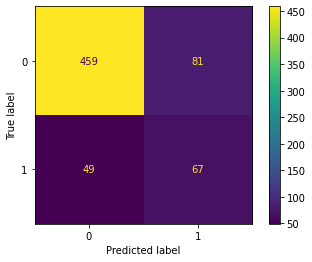

In [109]:
final_model = VotingClassifier(estimators=[("RF", opt_RF.best_estimator_), ("XGB", opt_XGB.best_estimator_)], voting="soft")
final_model.fit(x_train, y_train)

y_pred_train = final_model.predict(x_train)
y_pred_test = final_model.predict(x_test)

dump(final_model, "model/final_model.joblib")
score(y_train, y_pred_train, y_test, y_pred_test)

# Explain Features

In [ ]:
# explainer = shap.TreeExplainer(final_model)
# shap_values = explainer.shap_values(data_proc[training_columns])

# shap.summary_plot(shap_values, X)

# Semi Supervised Learning

In [101]:
training_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon', 'Trihalomethanes', 'Turbidity']
predict_column = ['Potability']

X_semi_sup, y_semi_sup_true = data_proc[training_columns], data_proc[predict_column].to_numpy()

y_semi_sup = y_semi_sup_true.copy()
y_semi_sup[500:] = -1 #Consider as if we already knew a lot about that dataset

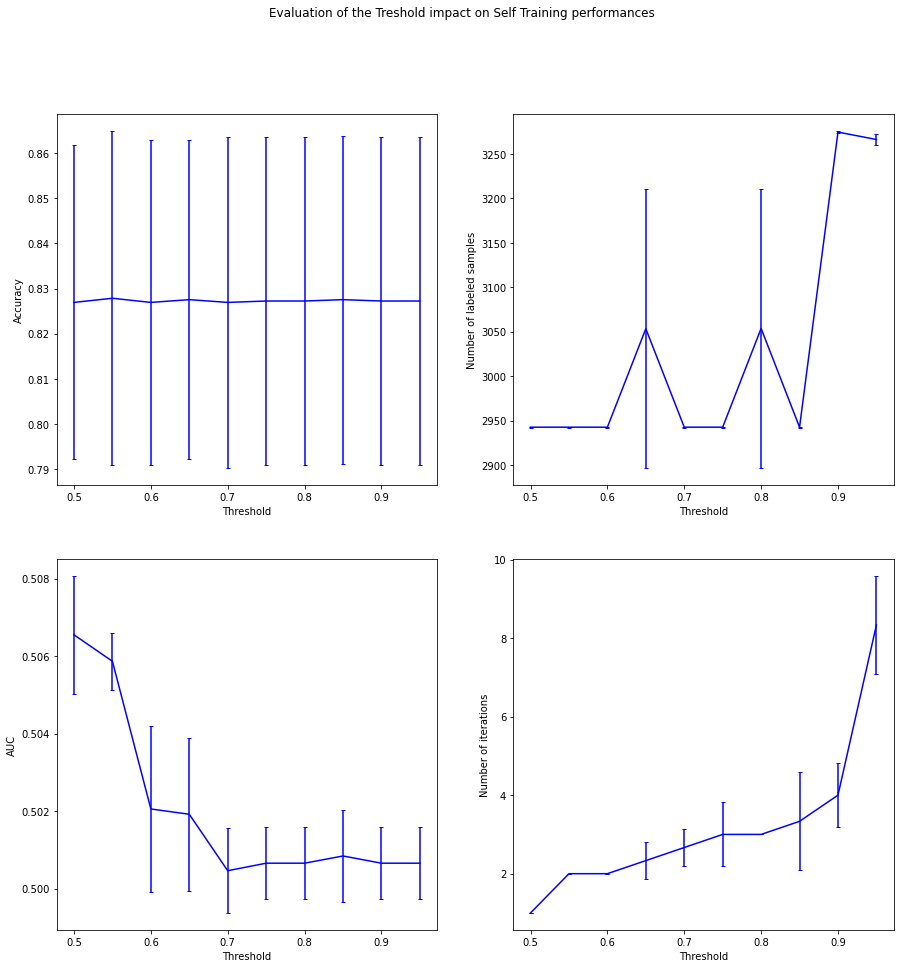

In [105]:
n_splits = 3

total_samples = y_semi_sup.shape[0]

base_classifier = final_model

threshold_values = np.arange(0.5, 1.00, 0.05)
scores_accuracy = np.empty((threshold_values.shape[0], n_splits))
scores_auc = np.empty((threshold_values.shape[0], n_splits))
amount_labeled = np.empty((threshold_values.shape[0], n_splits))
max_iter = np.empty((threshold_values.shape[0], n_splits))

for i, threshold in enumerate(threshold_values):
    self_training_model = SelfTrainingClassifier(base_classifier,
                                           threshold=threshold)
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X_semi_sup, y_semi_sup)):
        X_train = X_semi_sup.iloc[train_index,:]
        y_train = y_semi_sup[train_index]
        X_test = X_semi_sup.iloc[test_index,:]
        y_test = y_semi_sup[test_index]
        y_test_true = y_semi_sup_true[test_index]

        self_training_model.fit(X_train, y_train)

        y_pred = self_training_model.predict(X_test)
        scores_accuracy[i, fold] = accuracy_score(y_test_true, y_pred)
        scores_auc[i, fold] = roc_auc_score(y_test_true, y_pred)
        
        # The amount of labeled samples that at the end of fitting
        amount_labeled[i, fold] = total_samples - np.unique(
            self_training_model.labeled_iter_, return_counts=True)[1][0]
        # The last iteration the classifier labeled a sample in
        max_iter[i, fold] = np.max(self_training_model.labeled_iter_)


# We plot the different quantities thanks to an errorbar, i.e we display mean and standard deviation in the plot
fig, ax = plt.subplots(2,2, figsize=(15,15))
fig.suptitle('Evaluation of the Treshold impact on Self Training performances')
ax[0, 0].errorbar(threshold_values, scores_accuracy.mean(axis=1),
             yerr=scores_accuracy.std(axis=1),
             capsize=2, color='b')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_xlabel('Threshold')

ax[1, 0].errorbar(threshold_values, scores_auc.mean(axis=1),
             yerr=scores_auc.std(axis=1),
             capsize=2, color='b')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].set_xlabel('Threshold')

ax[0, 1].errorbar(threshold_values, amount_labeled.mean(axis=1),
             yerr=amount_labeled.std(axis=1),
             capsize=2, color='b')
ax[0, 1].set_ylabel('Number of labeled samples')
ax[0, 1].set_xlabel('Threshold')

ax[1, 1].errorbar(threshold_values, max_iter.mean(axis=1),
             yerr=max_iter.std(axis=1),
             capsize=2, color='b')
ax[1, 1].set_ylabel('Number of iterations')
ax[1, 1].set_xlabel('Threshold')


plt.show()

In [123]:
(final_model.predict_proba(x_train)>0.8).sum(axis=1)

array([1, 1, 1, ..., 1, 1, 1])